In [122]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import sklearn.preprocessing as prepro
%matplotlib inline


## Assume we have the image

Can't figure out svg,

so I'll assume we have a list of words

Each word is a 50 x 200 (pixel) matrix, gray scale, containing one word


Can be modified, but I'll suppose the images are pre processed correctly
- 0 is white
- 1 is black
- no low value, either it's white, either it's bigger than 0.5
- all the light gray between 0 and 0.5 is erased by 0

In [16]:
list_of_words = []
for _ in range(10):
    word = np.random.rand(50,200)
    word[word < 0.9] = 0
    list_of_words.append(word)

print(list_of_words[0])

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.93970856 0.        ]
 [0.         0.         0.99130891 ... 0.         0.         0.        ]]


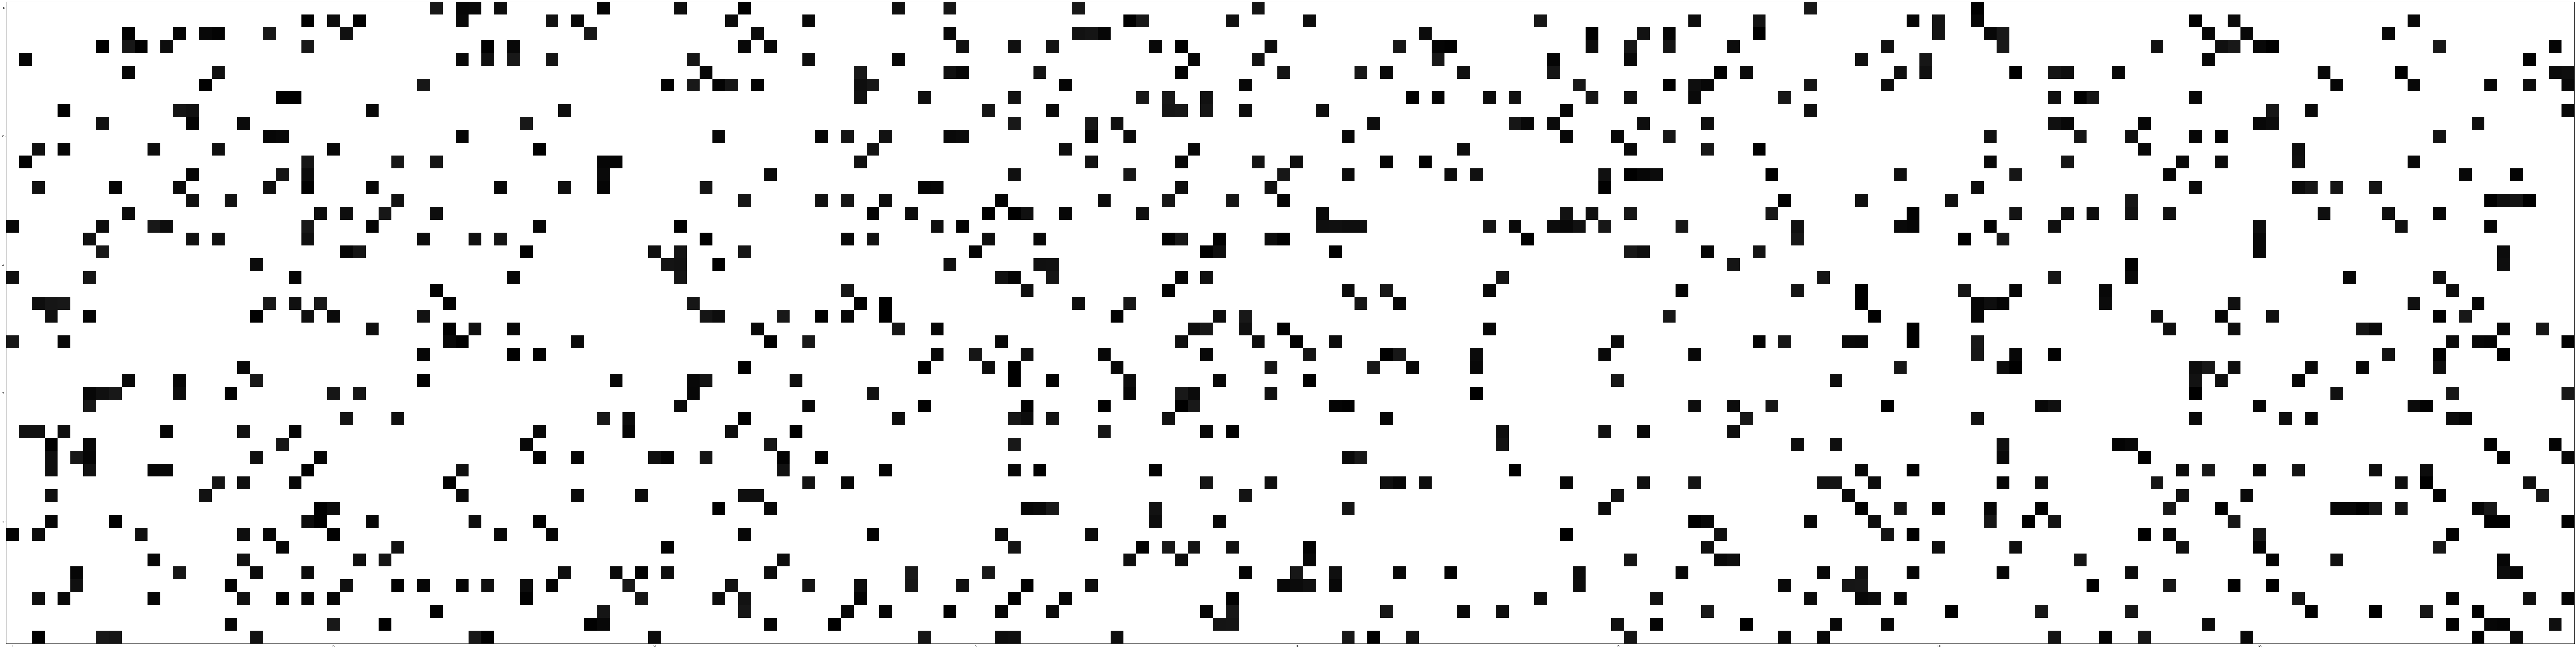

In [19]:
test_image = list_of_words[0]

plt.figure(figsize=(200,800))
plt.imshow(test_image,cmap="gray_r",interpolation="none")
plt.show()

# Let's imagine this is my word 
# 0 = white and 1 = black

In [76]:
test_slice = test_image[:,0]
test_slice[18] = 0.9837
test_slice[19] = 0.8437
test_slice

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.96122124, 0.9837    , 0.8437    ,
       0.        , 0.93544039, 0.        , 0.        , 0.        ,
       0.        , 0.90901681, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.98719534, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

### Features

In [107]:
# features:
#We'll have a sliding 1 pixel band, so slice = 50 x 1

# feature 1
# lower contour

def lower_contour(slice):

    index = np.where(slice >= 0.5)[0]
    
    if len(index) == 0:
        return 0
    else:
        return np.max(index)

# feature 2
# upper contour

def upper_contour(slice):

    index = np.where(slice >= 0.5)[0]
    
    if len(index) == 0:
        return len(slice)
    else:
        return np.min(index)

# feature 3
# fraction of black pixel

def fraction_black(slice):

    number = len(np.where(slice >= 0.5)[0])

    if number == 0:
        return 0.0
    else:
        return number/len(slice)

# feature 4
# fraction of black pixel between the highest and lower contour

def fraction_black_between(slice):

    number = len(np.where(slice >= 0.5)[0])

    

    if number == 0:
        return 0.0
    else:

        index_min = np.min(np.where(slice >= 0.5))
        index_max = np.max(np.where(slice >= 0.5))

        return fraction_black(slice[index_min:index_max+1])

# feature 5
# number of black white transition
def transition_black_white(slice):

    counter = 0
    was_on_black = False

    for i in range(len(slice)):

        if slice[i] >= 0.5 and was_on_black == False:
            was_on_black = True
        
        elif slice[i] < 0.5 and was_on_black == True:
            was_on_black = False
            counter += 1
    
    return counter

number_of_features = 5
    

In [108]:
print(lower_contour(test_slice))
print(upper_contour(test_slice))
print(fraction_black(test_slice))
print(fraction_black_between(test_slice))
print(transition_black_white(test_slice))

41
17
0.12
0.24
4


In [109]:
test_slice_empty = test_image[:,31]
test_slice_empty

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [112]:
print(lower_contour(test_slice_empty))
print(upper_contour(test_slice_empty))
print(fraction_black(test_slice_empty))
print(fraction_black_between(test_slice_empty))
print(transition_black_white(test_slice_empty))

0.0
50
0.0
0.0
0


### Sliding windows

For a word (50 x 200), compute the equivalent features sequences (5 x 200), for each slice, compute the features points in a R^5 dim space

In [114]:
rep = []
test_image.shape[1]
i = 0
for i in range(test_image.shape[1]):
    
    feature_vector = [lower_contour(test_image[:,i]),upper_contour(test_image[:,i]),fraction_black(test_image[:,i]),fraction_black_between(test_image[:,i]),transition_black_white(test_image[:,i])]
    rep.append(feature_vector)

array = np.asarray(rep)

In [119]:
array.mean(axis=0)

array([40.91      ,  8.835     ,  0.1002    ,  0.17991782,  4.415     ])

In [124]:
normed = prepro.normalize(array,axis=0,norm="l2")
normed

array([[0.06919183, 0.09417885, 0.07798129, 0.07440653, 0.05921541],
       [0.05569099, 0.02215973, 0.03899064, 0.03100272, 0.04441156],
       [0.08269268, 0.06093926, 0.09097817, 0.05564591, 0.08882312],
       [0.06750423, 0.12741845, 0.09097817, 0.12056614, 0.05921541],
       [0.07762986, 0.04431946, 0.07798129, 0.04769649, 0.08882312],
       [0.07594226, 0.19389763, 0.03899064, 0.08455287, 0.02960771],
       [0.0607538 , 0.09971878, 0.10397505, 0.13053777, 0.07401927],
       [0.08269268, 0.0166198 , 0.07798129, 0.03957794, 0.07401927],
       [0.08269268, 0.07755905, 0.05198752, 0.03444747, 0.04441156],
       [0.04894056, 0.01107986, 0.06498441, 0.055362  , 0.05921541],
       [0.06919183, 0.0166198 , 0.02599376, 0.01589883, 0.02960771],
       [0.07762986, 0.06093926, 0.06498441, 0.04305933, 0.07401927],
       [0.0607538 , 0.0166198 , 0.05198752, 0.03647379, 0.05921541],
       [0.07425465, 0.01107986, 0.07798129, 0.04325961, 0.07401927],
       [0.0303769 , 0.04431946, 0.

In [125]:
def compute_features_vector(image):

    rep = []
    for i in range(image.shape[1]):
        feature_vector = [lower_contour(image[:,i]),upper_contour(image[:,i]),fraction_black(image[:,i]),fraction_black_between(image[:,i]),transition_black_white(image[:,i])]
        rep.append(feature_vector)
    
    array = np.asarray(rep)

    normed = prepro.normalize(array,axis=0,norm="l2")
    
    return normed
        

In [126]:
compute_features_vector(test_image)

array([[0.06919183, 0.09417885, 0.07798129, 0.07440653, 0.05921541],
       [0.05569099, 0.02215973, 0.03899064, 0.03100272, 0.04441156],
       [0.08269268, 0.06093926, 0.09097817, 0.05564591, 0.08882312],
       [0.06750423, 0.12741845, 0.09097817, 0.12056614, 0.05921541],
       [0.07762986, 0.04431946, 0.07798129, 0.04769649, 0.08882312],
       [0.07594226, 0.19389763, 0.03899064, 0.08455287, 0.02960771],
       [0.0607538 , 0.09971878, 0.10397505, 0.13053777, 0.07401927],
       [0.08269268, 0.0166198 , 0.07798129, 0.03957794, 0.07401927],
       [0.08269268, 0.07755905, 0.05198752, 0.03444747, 0.04441156],
       [0.04894056, 0.01107986, 0.06498441, 0.055362  , 0.05921541],
       [0.06919183, 0.0166198 , 0.02599376, 0.01589883, 0.02960771],
       [0.07762986, 0.06093926, 0.06498441, 0.04305933, 0.07401927],
       [0.0607538 , 0.0166198 , 0.05198752, 0.03647379, 0.05921541],
       [0.07425465, 0.01107986, 0.07798129, 0.04325961, 0.07401927],
       [0.0303769 , 0.04431946, 0.

## Test with images...

Need to split an image (for example 270.jpg) into a multiples of scaled 50x200 images containing one word. The file 270.svg contains the path around each word

- load image
- load svg
- for each path in the svg:
    - apply the path to the image
    - remove what is outside, keep inside
    - fill around the path with blank to have the smallest possible box around the word
    - scale the box to a fixed size (50 x 200?)


In [2]:
img = Image.open("data/images/270.jpg").convert("L")

#img.show()

In [3]:
data = np.asarray(img)

data.shape

(3311, 2035)

In [5]:
import svgpathtools as svgt

svg_string="data/ground-truth/locations/270.svg"

In [7]:
paths, attributes = svgt.svg2paths(svg_string)

In [8]:
redpath = paths[0]
redpath_attribs = attributes[0]
print(redpath)
print(redpath_attribs['id'])

Path(Line(start=(112+170j), end=(112+230j)),
     Line(start=(112+230j), end=(129.27+231.5j)),
     Line(start=(129.27+231.5j), end=(132+230j)),
     Line(start=(132+230j), end=(232+230j)),
     Line(start=(232+230j), end=(240+238j)),
     Line(start=(240+238j), end=(299.69+148.25j)),
     Line(start=(299.69+148.25j), end=(192+157j)),
     Line(start=(192+157j), end=(112+170j)))
270-01-01


In [10]:
print(redpath.d())

M 112.0,170.0 L 112.0,230.0 L 129.27,231.5 L 132.0,230.0 L 232.0,230.0 L 240.0,238.0 L 299.69,148.25 L 192.0,157.0 L 112.0,170.0


In [ ]:
url="data/ground-truth/locations/270.svg"

In [7]:
test = svg.svg2png(url="data/ground-truth/locations/270.svg",output_width=img.width,output_height=img.height)

In [1]:
from xml.dom import minidom
from svg.path import parse_path

In [3]:
svg_dom = minidom.parseString(svg_string)

path_strings = [path.getAttribute('d') for path in svg_dom.getElementsByTagName('path')]

for path_string in path_strings:
    path_data = parse_path(path_string)


ExpatError: not well-formed (invalid token): line 1, column 4

In [14]:
file = open("data/ground-truth/locations/270.svg")
svg = file.read()
svg = svg.decode("utf-8")


AttributeError: 'str' object has no attribute 'decode'